# Code to produce figure from WAVES proceeding

Zoïs Moitier, Camille Carvalho
            
_Karlsruhe Institute of Technology, Germany, INSA Lyon, UC Merced_

In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))
import src.helmholtz as hel
import src.utils as utils

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from math import sqrt
from matplotlib.colors import LogNorm

%matplotlib inline

## Internal plotting functions

In [3]:
def set_rcParams(font_size=10, line_width=1):
    """Set rcParam of matplotlib."""
    parameters = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": font_size,
        "font.size": font_size,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": font_size,
        "xtick.major.width": 0.5,
        "xtick.labelsize": font_size-5,
        "ytick.major.width": 0.5,
        "ytick.labelsize": font_size-5,
        # Line properties
        "lines.linewidth": line_width,
        "axes.linewidth": 0.5,
        "grid.linewidth": 0.25,
    }
    return parameters

def set_size(width=370.38374, frac_width=1, frac_height=None):
    """Set size for plot."""
    # Width of figure (in pts)
    fig_width = width * frac_width
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    inv_golden_ratio = (sqrt(5) - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width * inches_per_pt
    # Figure height in inches
    if frac_height is None:
        fig_height_in = fig_width_in * inv_golden_ratio
    else:
        fig_height_in = fig_width_in * frac_height

    return (fig_width_in, fig_height_in)


In [4]:
def calc_err(result, tt_trace):
    θ = result.grid
    u_ana = tt_trace[0](θ)
    v_ana = tt_trace[1](θ)
    u_num = result.trace
    v_num = result.scaled_normal_trace

    return (
        np.abs(u_num - u_ana).max() / np.abs(u_ana).max(),
        np.abs(v_num - v_ana).max() / np.abs(v_ana).max(),
    )

## 1) Function plotting error with respect to $\varepsilon$

In [5]:
def plot_err(param):
    ɛ_vec = param["ɛ_vec"]
    nb_ɛ = np.size(ɛ_vec, 0)

    α = param["α"]
    k = param["k"]
    type_wave = param["type_wave"]
    m = param["m"]

    N = param["N"]

    solvers = [
        hel.bie.get_total_field_pqr,
        hel.bie.get_total_field_qpax,
    ]

    err_u = np.zeros((nb_ɛ, len(solvers)))
    err_v = np.zeros((nb_ɛ, len(solvers)))

    for s, solver in enumerate(solvers):

        for i, ɛ in enumerate(ɛ_vec):
            obs = hel.create_obstacle(
                ɛ=ɛ, bdy_type=hel.BoundaryType.PENETRABLE, σ=param["σ"], ρ=param["ρ"]
            )

            if type_wave.startswith("ful"):
                in_field = hel.analytic.plane_wave_field(obs, α, k, m)
            else:
                in_field = hel.analytic.create_one_field(obs, k, type_wave, 1, m)

            sc_field = hel.analytic.get_scatter_field(obs, in_field)
            tt_trace = hel.get_total_trace(obs, in_field, sc_field)

            err_u[i, s], err_v[i, s] = calc_err(
                solver(obs, k, hel.get_incident_trace_expansion(in_field), N), tt_trace
            )

    fig_size = [1.25 * e for e in [2 * 6.4, 4.8]]
    fig, axs = plt.subplots(ncols=2, figsize=set_size(frac_width=1), constrained_layout=True)

    marker_vec = ("o", "X")
    for n, leg in enumerate(param["legends"]):
        axs[0].loglog(ɛ_vec, err_u[:, n], f"{marker_vec[n]}--", label=leg)
        axs[1].loglog(ɛ_vec, err_v[:, n], f"{marker_vec[n]}--", label=leg)

    if param["slope"][0]:
        ε_ = np.array([1e-8, 1e-3])
        axs[0].loglog(ε_, 10 ** (-0.5) * ε_, "k", label=r"$\mathcal{O}(\varepsilon)$")
        axs[1].loglog(ε_, 10 ** (-0.5) * ε_, "k", label=r"$\mathcal{O}(\varepsilon)$")

    if param["slope"][1]:
        ε_ = np.array([1e-7, 1e-3])
        axs[0].loglog(ε_, ε_**2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$")
        axs[1].loglog(ε_, ε_**2, "k--", label=r"$\mathcal{O}(\varepsilon^2)$")

    for ax in axs:
        # ax.set_xlim(*param["xlim"])
        ax.set_xlabel(r"$\varepsilon$", fontsize=15)
        # ax.set_ylim(*param["ylim"])
        ax.set_ylabel("relative error", fontsize=15)
        ax.grid(True)
        ax.legend(fontsize=6, loc = 'lower right')
        ax.legend(fontsize=15)
        ax.minorticks_off()
        #filename = f"error"
        #ext = "pdf"
        #fig.savefig(f"{filename}.{ext}", transparent=True, format=ext)

    return None

In [6]:
def plot_3(ε_vec, σ, ρ, α, k, type_wave, m, N, slope):
    plot_err(
        {
            "σ": σ,
            "ρ": ρ,
            "type_wave": type_wave,
            "m": m,
            "α": α,
            "k": k,
            "ɛ_vec": ɛ_vec,
            "N": N,
            "legends": ("PQR", "QPAX"),
            "slope": slope,
            "xlim": (1e-4, 1),
            "ylim": (1e-4, 1e2),
        }
    )
    return None

### Ellipse parameters

In [7]:
## Ellipse material parameters
σ = 1.1#parameter in the 2nd order term (div(σ grad u))
ρ = 1 #parameter in the compact term (k**2 ρ u)

In [8]:
## Incident field parameters
α = 0  # (cos(α), sin(α)) direction of the plane wave
k = 2  # wavenumber direction of the plane wave

In [9]:
## Discretization parameters
N = 200  # Number of quadrature points
m = 8  # Number of Mathieu functions in the series
nb_ɛ = 40  # Number of ε
ɛ_min, ɛ_max = 1e-8,  0.99 # Limits for ε
ɛ_vec = np.geomspace(ɛ_min, ɛ_max, num=nb_ɛ)

### Relative error for full solution

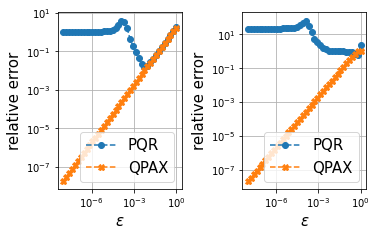

In [10]:
plot_3(ɛ_vec, σ, ρ, α, k, "ful", m, N, (False, False))

## 2) Heatmap of the error with respect to $\varepsilon$ and N

In [11]:
def plot_err_heatmap(param):
    ɛ_vec = param["ɛ_vec"]
    ɛ_str = param["ɛ_str"]
    bdy_type = param["bdy_type"]

    α = param["α"]
    k = param["k"]
    m = param["m"]
    N_vec = param["N_vec"]
    
    solvers = [
        hel.bie.get_total_field_pqr,
        hel.bie.get_total_field_qpax,
    ]
    
    solver_labels = [
        "PQR",
        "QPAX",
    ]

    err_u = np.empty((len(solvers), len(ɛ_vec), len(N_vec)))
    err_v = np.empty((len(solvers), len(ɛ_vec), len(N_vec)))

    for s, solver in enumerate(solvers):

        for i, ɛ in enumerate(ɛ_vec):
            obs = hel.create_obstacle(
                ɛ=ɛ, bdy_type=hel.BoundaryType.PENETRABLE, σ=param["σ"], ρ=param["ρ"]
            )
            in_field = hel.analytic.plane_wave_field(obs, α, k, m)
            sc_field = hel.analytic.get_scatter_field(obs, in_field)
            tt_trace = hel.get_total_trace(obs, in_field, sc_field)
            
            for j, N in enumerate(N_vec):
                err_u[s, i, j], err_v[s, i, j] = calc_err(
                solver(obs, k, hel.get_incident_trace_expansion(in_field), N), tt_trace
            )
        plt.rcParams.update(set_rcParams(font_size=8))
        fig_size = [1.25 * e for e in [6.4, 4.8]]
        fig, ax = plt.subplots(figsize=set_size(frac_width=0.49), constrained_layout=True)

        log_norm_err = LogNorm(1e-8, 1e1) #err_u[s,:,:].min(), err_u[s,:,:].max()) 
        sns.heatmap(
        err_u[s,:,:],
        ax=ax,
        cmap="YlGnBu_r",
        norm=log_norm_err,
        xticklabels=N_vec,
        yticklabels=[f"{x:.1e}" for x in ɛ_vec],
        )
        ax.set_xlabel(r"$2N$", fontsize=10)
        ax.set_ylabel(r"$\varepsilon$", fontsize=10)
        ax.set_aspect("equal", "box")
        cbar_ax = fig.axes[-1]
        cbar_ax.tick_params(which="minor", length=0, labelsize=10)
        #filename = f"error_u_{solver_labels[s]}"
        #ext = "pdf"
        #fig.savefig(f"{filename}.{ext}", transparent=True, format=ext)
        
        fig_size = [1.25 * e for e in [6.4, 4.8]]
        fig, ax = plt.subplots(figsize=set_size(frac_width=0.49), constrained_layout=True)
        log_norm_err_v = LogNorm(1e-8, 1e1) #err_v[s,:,:].min(), err_v[s,:,:].max())
        sns.heatmap(
            err_v[s,:,:],
            ax=ax,
            cmap="YlGnBu_r",
            norm=log_norm_err_v,
            xticklabels=N_vec,
            yticklabels=[f"{x:.1e}" for x in ɛ_vec],
        )
        ax.set_xlabel(r"$2N$", fontsize=10)
        ax.set_ylabel(r"$\varepsilon$", fontsize=10)
        ax.set_aspect("equal", "box")
        cbar_ax = fig.axes[-1]
        cbar_ax.tick_params(which="minor", length=0, labelsize=10)
        #filename = f"error_v_{solver_labels[s]}"
        #ext = "pdf"
        #fig.savefig(f"{filename}.{ext}", transparent=True, format=ext)
    return None

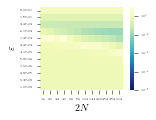

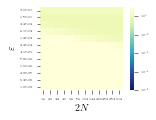

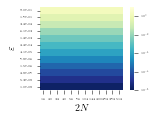

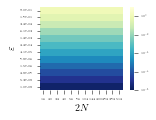

In [12]:
N_min, N_max = 16, 512
nb_N = 12
N_vec = utils.logspace_quadrature(N_min, N_max, nb_N)

ɛ_min, ɛ_max = 1e-8, 0.9
nb_ɛ = 12
ɛ_vec = utils.logspace_epsilon(ɛ_min, ɛ_max, nb_ɛ)[::-1]
ɛ_str = [f"{x:.1e}" for x in ɛ_vec]

plot_err_heatmap(
    {
        "bdy_type": hel.BoundaryType.PENETRABLE,
        "ɛ_vec": ɛ_vec,
        "ɛ_str": ɛ_str,
        "α": α,
        "σ": σ,
        "ρ": ρ,
        "k": k,
        "m": m,
        "N_vec": N_vec,
    }
)